# Imports




In [ ]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Segmentation Models: using `keras` framework.


In [ ]:
root_directory = 'Semantic segmentation dataset/'

patch_size = 256

# Read images



In [ ]:
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images': 
        images = os.listdir(path)
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"): 
                image = cv2.imread(path+"/"+image_name, 1) 
                SIZE_X = (image.shape[1]//patch_size)*patch_size 
                SIZE_Y = (image.shape[0]//patch_size)*patch_size 
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y)) 
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                

Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_003.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_004.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_005.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_006.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_007.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_008.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_009.jpg
Now patchifying image: Semantic segmentation dataset/Tile 2\images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 2\images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/T

In [ ]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks': 
        masks = os.listdir(path)
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):
               
                mask = cv2.imread(path+"/"+mask_name, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))
                mask = np.array(mask)             
       
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]                           
                        mask_dataset.append(single_patch_mask) 

Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_003.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_004.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_005.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_006.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_007.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_008.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_009.png
Now patchifying mask: Semantic segmentation dataset/Tile 2\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset/Tile 2\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset/Tile 2\masks/image_part_

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

#  Convert to RGB


In [ ]:
a=int('3C', 16)
print(a)

60


In [ ]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

In [ ]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


In [ ]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

from simple_multi_unet_model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

In [ ]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=8, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/8
66/66 [==============================] - 554s 8s/step - loss: 0.9919 - accuracy: 0.5690 - jacard_coef: 0.3003 - val_loss: 0.9765 - val_accuracy: 0.6479 - val_jacard_coef: 0.4207
Epoch 2/8
66/66 [==============================] - 608s 9s/step - loss: 0.9629 - accuracy: 0.6932 - jacard_coef: 0.4371 - val_loss: 0.9656 - val_accuracy: 0.6975 - val_jacard_coef: 0.4616
Epoch 3/8
66/66 [==============================] - 649s 10s/step - loss: 0.9499 - accuracy: 0.7407 - jacard_coef: 0.4960 - val_loss: 0.9652 - val_accuracy: 0.7027 - val_jacard_coef: 0.4772
Epoch 4/8
66/66 [==============================] - 627s 9s/step - loss: 0.9433 - accuracy: 0.7591 - jacard_coef: 0.5261 - val_loss: 0.9628 - val_accuracy: 0.7178 - val_jacard_coef: 0.5035
Epoch 5/8
66/66 [==============================] - 507s 8s/step - loss: 0.9379 - accuracy: 0.7762 - jacard_coef: 0.5589 - val_loss: 0.9597 - val_accuracy: 0.7157 - val_jacard_coef: 0.5067
Epoch 6/8
66/66 [==============================] - 554s 8s/

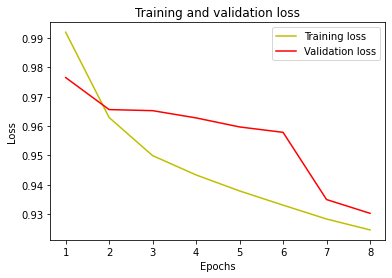

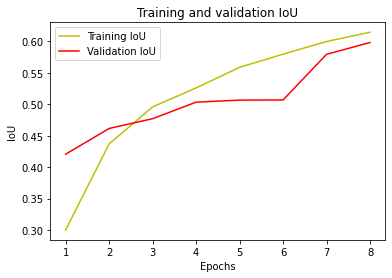

In [ ]:
# history = history1
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# acc = history.history['jacard_coef']
# val_acc = history.history['val_jacard_coef']

# plt.plot(epochs, acc, 'y', label='Training IoU')
# plt.plot(epochs, val_acc, 'r', label='Validation IoU')
# plt.title('Training and validation IoU')
# plt.xlabel('Epochs')
# plt.ylabel('IoU')
# plt.legend()
# plt.show()

# IoU


In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

9/9 [==============================] - 24s 3s/step


In [ ]:
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.48879305


# Prediction



1/1 [==============================] - 0s 124ms/step


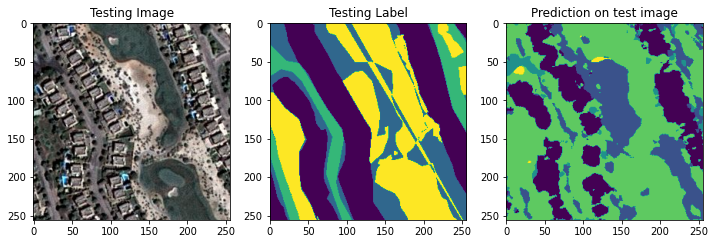

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

#####################################################################